# Importing all necessary libraries

In [217]:
import json
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from operator import itemgetter
from pathlib import Path

import math
import scipy.stats as st # used for confidence interval
import matplotlib.patches as mpatches # used for rectangles in plots
from sklearn.cluster import KMeans # used for K-Means Clustering

# Loading dataset on number of suicides and gdp in different countries for multiple years
<b> Data availability in each year differs by country and by year </b> <br/>
<b> GDP per capita is the same across all demographic groups of a country in a given year </b>

In [218]:
df = pd.read_csv(Path.cwd() / 'suicide_vs_gdp_per_capita.csv')

In [219]:
df

,country,year,sex,age,suicides_no,population,suicide_per_hundred_k_pop,country-year,HDI for year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [220]:
countries = sorted(list(set(df.loc[:,'country'])))
# countries

# Creating a protype visualization only using data from Albania
## Create a dictionary containing data on years and suicide rates & GDP per capita of that year from the dataset

In [221]:
albania = {}
df_albania = df.loc[df['country']=='Albania'] # df filtered to country == Albania
albania_years = df_albania.loc[:, 'year'] # pd series of years (overlaps due to different demographic groups)
albania['years'] =  sorted(list(set(albania_years))) # unique list(range) of years

albania_gdp_per_capita = []
albania_suicide_per_hundred_k_pop = []
for year in albania['years']:
    
    try: # ensure all gdp_per_capita in a given year is same across demographic groups
        gdp_pc = list(df_albania.loc[df['year']==year, ['gdp_per_capita']].squeeze())
        
        if not all(list(map((lambda x: x==gdp_pc[0]), gdp_pc))):
            raise Exception(f"invalid gdp_per_capita data")
    except Exception as e:
        print(e)
    else:
        albania_gdp_per_capita.append(gdp_pc[0])
        
    suicide_count = sum(list(df_albania.loc[df['year']==year, ['suicides_no']].squeeze()))
    population = sum(list(df_albania.loc[df['year']==year, ['population']].squeeze()))
    suicide_per_hundred_k_pop = (10**5)*suicide_count/population
    albania_suicide_per_hundred_k_pop.append(suicide_per_hundred_k_pop)
albania['gdp_per_capita'] = albania_gdp_per_capita
albania['suicide_per_hundred_k_pop'] = albania_suicide_per_hundred_k_pop
# albania['suicide_per_hundred_k_pop']
# len(albania['suicide_per_hundred_k_pop']) == len(albania['gdp_per_capita'])
# len(albania['years'])==len(albania['gdp_per_capita'])
# pprint(albania)

## Helper functions to encode area and color of data points
### function to return a list of area for points at corresponding index to encode suicide rate

In [222]:
def suicide_rate2area(suicide_rates): # function to return a list of area for points at corresponding index
    area_list = []
    for rate in suicide_rates:
        area_list.append(50*rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return area_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

### function to return a list of area for points at corresponding index to encode GDP per capita

In [223]:
def suicide_rate2area_ver2(suicide_rates): # function to return a list of area for points at corresponding index
    area_list = []
    for rate in suicide_rates:
        area_list.append(0.0001*rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return area_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

### function to return a list of color for points at corresponding index (can encode both suicide rate and GDP per capita

In [224]:
def suicide_rate2color(suicide_rates):
    color_list = []
    for rate in suicide_rates:
        color_list.append(rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return color_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

## Encoding Test
### Encoding Suicide Rate on y-axis and GDP per capita as color + area of points
<b>Does not effectively display the pattern of subject</b><br/>
<b>Encode GDP per capita on y-axis and Suicide Rate as area<b>

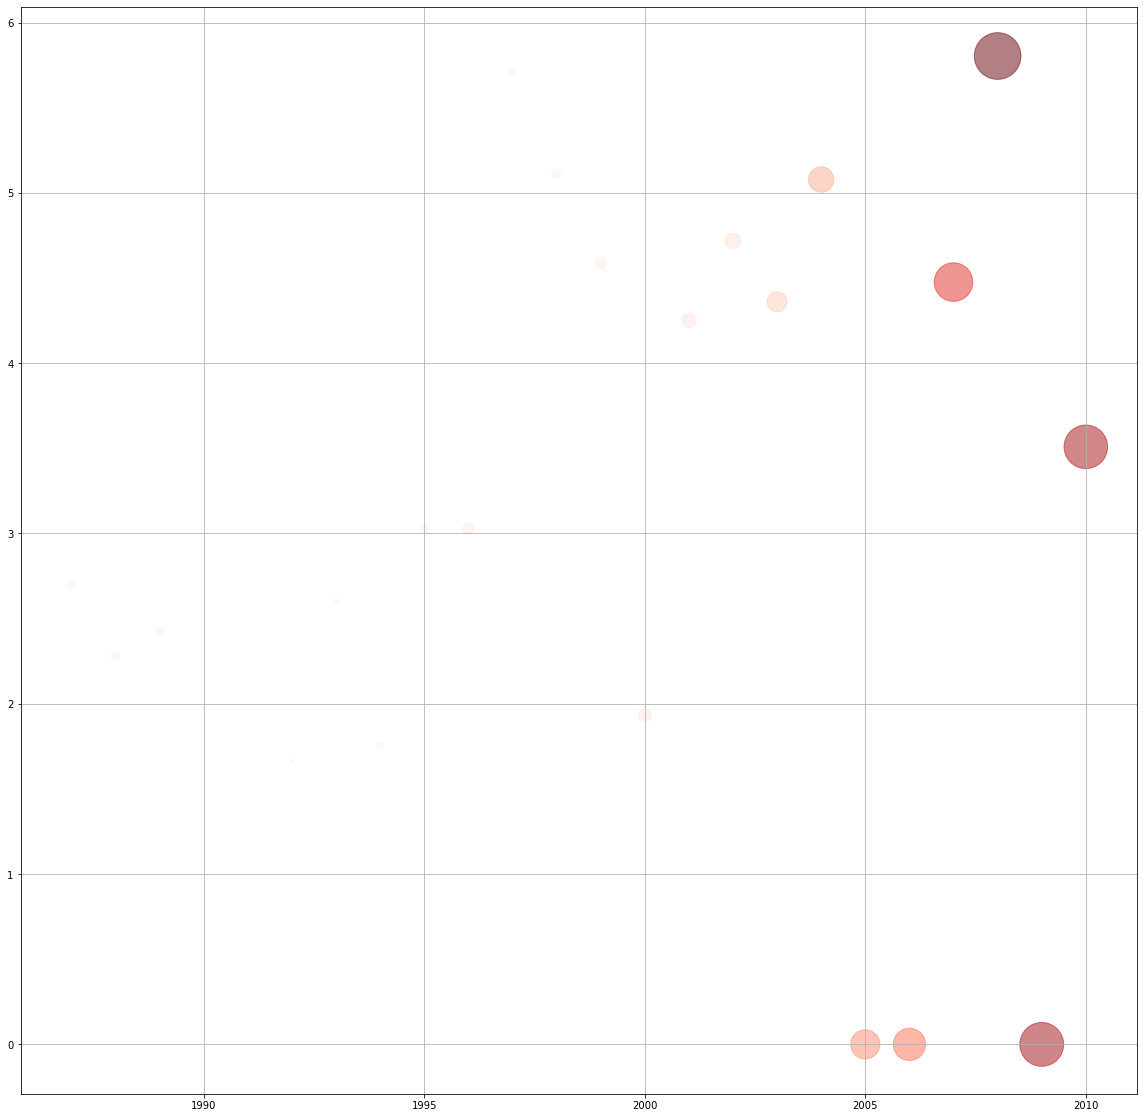

In [225]:
fig, ax = plt.subplots(1,1)
# color_map = plt.cm.get_cmap('Reds')
ax.scatter(albania['years'], albania['suicide_per_hundred_k_pop'], 
           c = suicide_rate2color(albania['gdp_per_capita']), cmap = plt.cm.get_cmap('Reds'), 
           s = suicide_rate2area_ver2(albania['gdp_per_capita']), 
           alpha = 0.5)
plt.rcParams["figure.figsize"] = (20, 10)
ax.grid()
plt.show()

### Encoding GDP per capita on y-axis and suicide rate as color + area of points
<b>Effectively displays the pattern of subject:</b><br/>
<b>Suicide rate increases as GDP per capita increases</b>

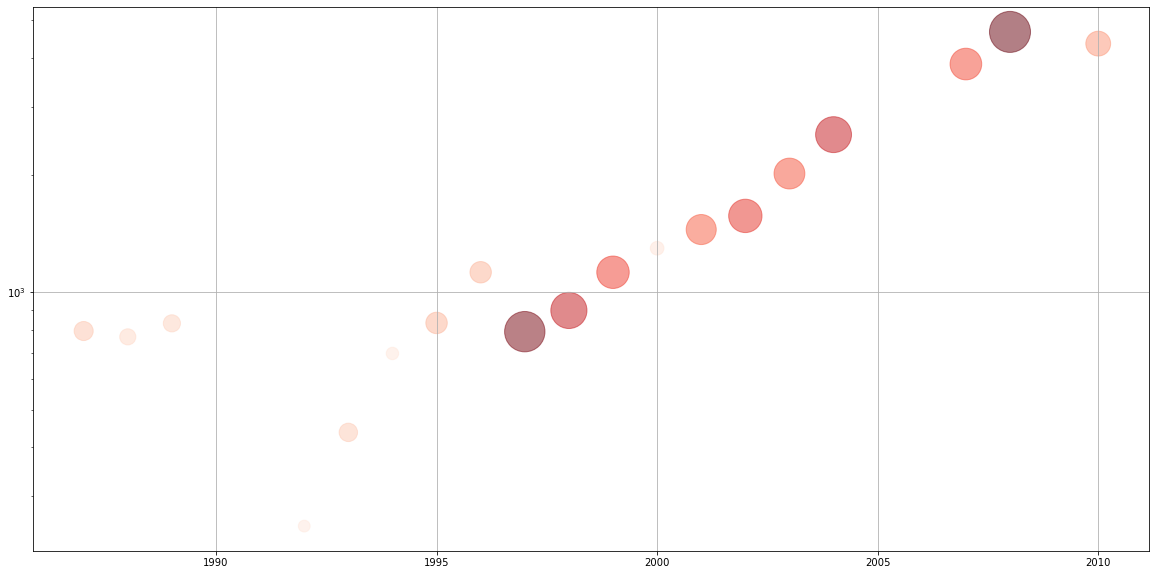

In [226]:
fig, ax = plt.subplots(1,1)
# color_map = plt.cm.get_cmap('Reds')
ax.scatter(albania['years'], albania['gdp_per_capita'], 
           c = suicide_rate2color(albania['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'), 
           s = suicide_rate2area(albania['suicide_per_hundred_k_pop']), 
           alpha = 0.5)
plt.rcParams["figure.figsize"] = (20, 10)
plt.yscale('log')
ax.grid()
plt.show()

# Iterate over all countries in the dataset and plot them
## use country names as keys for a dictionary of dictionaries containing data like in section *3.1*

In [227]:
# dictionary to contain all relevant data about suicide rates and gdp per capita on existing countries:
data = {}
countries = sorted(list(set(df.loc[:,'country']))) # alphabetically sorted list of country names
for country in countries:
    data[country.lower()] = {}
    df_country = df.loc[df['country']==country] # df filtered to country name == country in loop
    country_years = df_country.loc[:, 'year'] # pd series of years (overlaps due to different demographic groups)
    data[country.lower()]['years'] =  sorted(list(set(country_years))) # unique list(range) of years
    
    country_gdp_per_capita = []
    country_suicide_per_hundred_k_pop = []
    for year in data[country.lower()]['years']:
        try: # ensure all gdp_per_capita in a given year is same across demographic groups
            gdp_pc = list(df_country.loc[df['year']==year, ['gdp_per_capita']].squeeze())

            if not all(list(map((lambda x: x==gdp_pc[0]), gdp_pc))):
                # raise exception if the first gdp_per_capita is not the same as all of the entries
                # in the list of gdp_per_capita values in a given year
                raise Exception(f"invalid gdp_per_capita data")
        except Exception as e:
            print(e)
        else:
            country_gdp_per_capita.append(gdp_pc[0])

        suicide_count = sum(list(df_country.loc[df['year']==year, ['suicides_no']].squeeze()))
        population = sum(list(df_country.loc[df['year']==year, ['population']].squeeze()))
        suicide_per_hundred_k_pop = (10**5)*suicide_count/population # 10**5 for (per 100k pop) factoring
        country_suicide_per_hundred_k_pop.append(suicide_per_hundred_k_pop)
    data[country.lower()]['gdp_per_capita'] = country_gdp_per_capita
    data[country.lower()]['suicide_per_hundred_k_pop'] = country_suicide_per_hundred_k_pop
data.keys()

dict_keys(['albania', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'barbados', 'belarus', 'belgium', 'belize', 'bosnia and herzegovina', 'brazil', 'bulgaria', 'cabo verde', 'canada', 'chile', 'colombia', 'costa rica', 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'dominica', 'ecuador', 'el salvador', 'estonia', 'fiji', 'finland', 'france', 'georgia', 'germany', 'greece', 'grenada', 'guatemala', 'guyana', 'hungary', 'iceland', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'kazakhstan', 'kiribati', 'kuwait', 'kyrgyzstan', 'latvia', 'lithuania', 'luxembourg', 'macau', 'maldives', 'malta', 'mauritius', 'mexico', 'mongolia', 'montenegro', 'netherlands', 'new zealand', 'nicaragua', 'norway', 'oman', 'panama', 'paraguay', 'philippines', 'poland', 'portugal', 'puerto rico', 'qatar', 'republic of korea', 'romania', 'russian federation', 'saint kitts and nevis', 'saint lucia', 'saint vincent and grenadines', '

## The cell below is deprecated:
because the color map is relative the range of values passed into the argument c in scatter( )<br/>
(suicide rates of one country over the years)<br/><br/>
however, it should account for the entire range of values<br/>
(suicide rates of all countries over the years)

<b>Initially tried to do what section *4.3* is doing<b>

In [228]:
# This cell is deprecated:
# because the color map is relative the range of values passed into the argument c in scatter()
#     (suicide rates of one country over the years)
# however, it should account for the entire range of values
#     (suicide rates of all countries over the years)

# fig, ax = plt.subplots(1,1)



# for country in data.keys():
#     country_data = data[country]
#     ax.scatter(country_data['years'], country_data['gdp_per_capita'], 
#                 c = suicide_rate2color(country_data['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 # color is relative to the data in a country
#                 s = suicide_rate2color(country_data['suicide_per_hundred_k_pop']),
#                 # color is relative to the data in a country
# #                 s = 100,
#                 alpha = 0.5)

    
# ax.set_xlabel("Time by year", fontsize = 20)
# ax.set_ylabel("GDP per capita", fontsize = 20)
# ax.set_title("GDP per capita and Suicide Rate of Countries by Year", fontsize=25)
             
             
# plt.rcParams["figure.figsize"] = (20, 20)
# plt.yscale('log')
# plt.grid()
# plt.show()

## Iterate over all country name keys in the dictionary of dictionaries containing relavant data from the dataset and plot them on the same graph
The plot below uses the same encodings as section <b>*3.3.2*<b/>

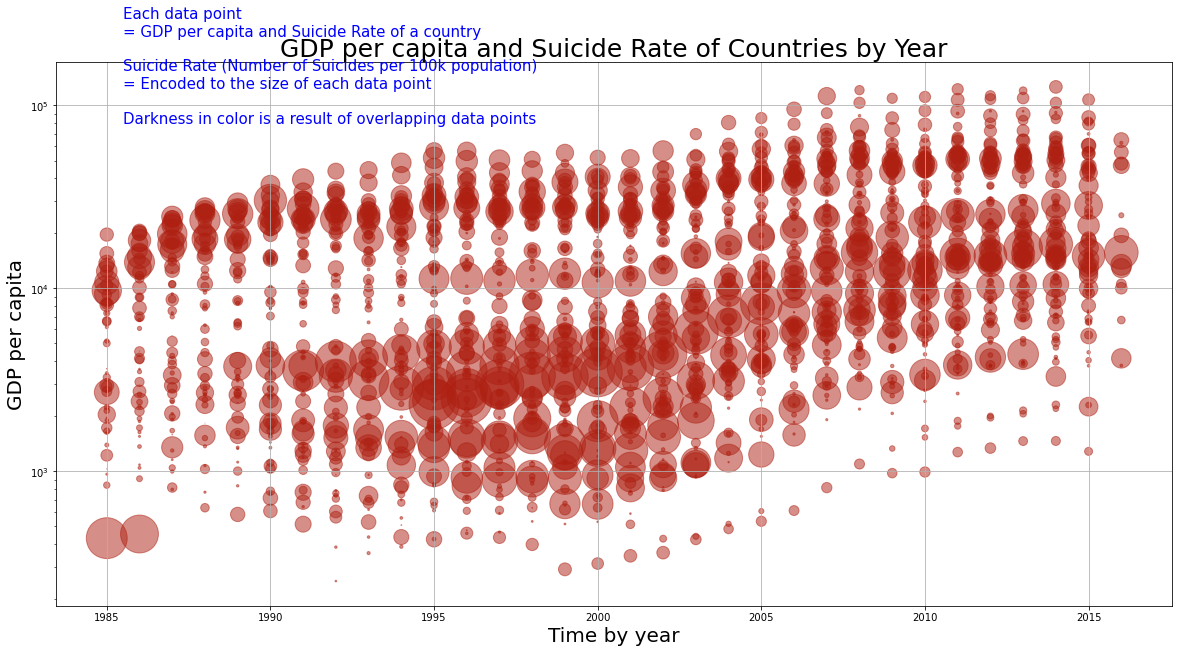

In [229]:
fig, ax = plt.subplots(1,1)

years_list = []
gdp_per_capita_list = []
suicide_per_hundred_k_pop_list = []

for country in data.keys():
    country_data = data[country]
    years_list.extend(country_data['years'])
    gdp_per_capita_list.extend(country_data['gdp_per_capita'])
    suicide_per_hundred_k_pop_list.extend(country_data['suicide_per_hundred_k_pop'])

    
ax.scatter(years_list, gdp_per_capita_list,
#                 c = suicide_rate2color(suicide_per_hundred_k_pop_list),
                c = '#ae2012',
#                 cmap = plt.cm.get_cmap('Reds'),
                s = suicide_rate2color(suicide_per_hundred_k_pop_list),
#                 s = 100,
                alpha = 0.5
          )

    
ax.set_xlabel("Time by year", fontsize = 20)
ax.set_ylabel("GDP per capita", fontsize = 20)
ax.set_title("GDP per capita and Suicide Rate of Countries by Year", fontsize=25)
             

annotation = "Each data point\n= GDP per capita and Suicide Rate of a country\
\n\nSuicide Rate (Number of Suicides per 100k population)\
\n= Encoded to the size of each data point\
\n\nDarkness in color is a result of overlapping data points"
plt.text(1985.5, 0.8*10**5, annotation, fontsize=15, color="blue") # adding annotation on plot
plt.rcParams["figure.figsize"] = (20, 20)
plt.yscale('log')
plt.grid()
plt.show()

## This cell below is deprecated:
because it was test-examining GDP per capita vs Suicide Rate relationship in countries:<br/>
    Republic of Korea, United States, Estonia, United Kingdom, Lithuania
    
*Area of potetial further exploration*

In [230]:
# # This cell is deprecated:
# # because it was test-examining GDP per capita vs Suicide Rate relationship in countries:
# #     Republic of Korea, United States, Estonia, United Kingdom, Lithuania
# max_change = -math.inf
# country_increase = ''
# min_change = math.inf
# country_decrease = ''
# for country in data.keys():
#     change = data[country]['suicide_per_hundred_k_pop'][-1] - data[country]['suicide_per_hundred_k_pop'][0]
#     if change > max_change:
#         max_change = change
#         country_increase = country
#     elif change < min_change:
#         min_change = change
#         country_decrease = country
# print(country_increase, max_change)
# print(country_decrease, min_change)




# fig, ax = plt.subplots(1,1)
# korea = data['republic of korea']
# us = data['united states']
# estonia = data['estonia']
# uk = data['united kingdom']
# lithuania = data['lithuania']

# ax.scatter(korea['years'], korea['gdp_per_capita'], 
# #                c = suicide_rate2color(korea['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 s = suicide_rate2color(korea['suicide_per_hundred_k_pop']),
# #                 s = 100,
#                 alpha = 0.5)
# ax.scatter(us['years'], us['gdp_per_capita'], 
# #                c = suicide_rate2color(us['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 s = suicide_rate2color(us['suicide_per_hundred_k_pop']),
# #                 s = 100,
#                 alpha = 0.5)
# ax.scatter(estonia['years'], estonia['gdp_per_capita'], 
# #                c = suicide_rate2color(estonia['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 s = suicide_rate2color(estonia['suicide_per_hundred_k_pop']),
# #                 s = 100,
#                 alpha = 0.5)
# ax.scatter(uk['years'], uk['gdp_per_capita'], 
# #                c = suicide_rate2color(uk['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 s = suicide_rate2color(uk['suicide_per_hundred_k_pop']),
# #                 s = 100,
#                 alpha = 0.5)
# ax.scatter(lithuania['years'], lithuania['gdp_per_capita'], 
# #                c = suicide_rate2color(lithuania['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'),
#                 s = suicide_rate2color(lithuania['suicide_per_hundred_k_pop']),
# #                 s = 100,
#                 alpha = 0.5)

    
# ax.set_xlabel("Time by year", fontsize = 20)
# ax.set_ylabel("GDP per capita", fontsize = 20)
# ax.set_title("GDP per capita and Suicide Rate of Countries by Year", fontsize=25)
             
             
# plt.rcParams["figure.figsize"] = (20, 20)
# plt.yscale('log')
# plt.grid()
# # plt.show()

# Analysis of section *4.3*

* GDP per capita for all countries are continuously growing with slight deterrences (likely due to economic crises within the country or globally).
* GDP per capita growths occured in clusters ranging in certain logarithmic brackets:
    * 2,000 to 15,000 USD
    * 10,000 to 40,000 USD
* In most years, while countries with exponentially higher or lower GDP per capita have relatively lower Suicide Rates, countries with medium to medium-low GDP per capita have considerably higher Suicide Rates.

# Conclusion

Unlike the initial hypothesis (Countries with lower GDP per capita has higher Suicide Rates),<br/>
**Countries with around mid-low GDP per capita has the highest Suicide Rates (largest data points).**

This may be attributed to socioeconomic polarization and cultural tension within countries with mid-low GDP per capita--the people in those countries might compare among themselves and to other countries more.<br>
*Area of further exploration*